# 1. Stochastic simulations in gempy

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"
import theano

In [1]:
import sys
sys.path.append(r'../../gempy/')
#if '/' in sys.path[0]:
#    sys.path.append(r'/home/elisa/PycharmProjects/gempy')
#elif '\\' in sys.path[0]:
#    sys.path.append(r'C:/users/elisa/documents/git/gempy')

import gempy as gp
#import vtk


import numpy as np
import matplotlib.pyplot as plt
#import evtk
#%matplotlib inline
#sys.path.append('C:\\Users\\elisa\\Documents\\git\\mplstereonet')
#import mplstereonet

In [2]:
gp

<module 'gempy' from '../../gempy/gempy/__init__.py'>

### Regular model setup

Active grids: ['regular']
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[ 100.        ,  100.        ,  100.        ],
       [ 100.        ,  100.        ,  300.        ],
       [ 100.        ,  100.        ,  500.        ],
       ...,
       [1000.        ,  200.        ,  974.6835443 ],
       [1000.        ,  200.        ,  987.34177215],
       [1000.        ,  200.        , 1000.        ]])

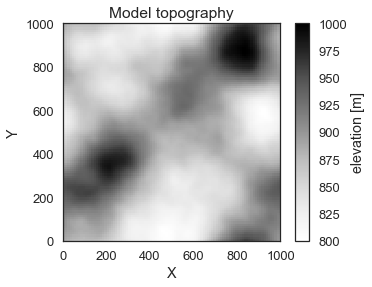

In [3]:
mode = 'map'
# I subdivide into map and 3d block because otherwhise the arrays become too big
# which results in a memory error

if mode == '3Dblock':
    resolution = [100,100,100]
elif mode == 'map':
    resolution = [5,5,5]
    
geo_model = gp.create_model('simplemodel')
# to speed up the computation, the 3d resolution is pretty low here.
# for comparison, use 2d slice of section s1 and topography.
gp.init_data(geo_model, extent=[0,1000,0,1000,0,1000],resolution = resolution,
                         path_i = "../data/faultuncertainty_interfaces_surface.csv",
                         path_o = "../data/faultuncertainty_orient_surface.csv")

gp.map_series_to_surfaces(geo_model, {'fault_series':'fault','form_series':('layer2','layer1','basement')})
geo_model.surfaces.colors.change_colors({'layer1': '#ffbe00', 'layer2': '#9f0052', 'fault': '#015482',
                                        'basement': '#728f02'})

geo_model.set_is_fault(['fault_series'],change_color=False)

if mode == 'map':
    geo_model.grid.set_section_grid({'s1':([0,200],[1000,200],[80,80])})#p1,p2,resolution
#geo_model.set_topography(source='random', d_z=np.array([800,1000]), fd=1.4)
geo_model.set_topography(source='saved', filepath='../data/topo.npy')
#geo_model.grid.topography.save('topo')

In [4]:
gp.set_interpolation_data(geo_model,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!


In [5]:
sol = gp.compute_model(geo_model, compute_mesh=False)

../../gempy/gempy/plot/visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


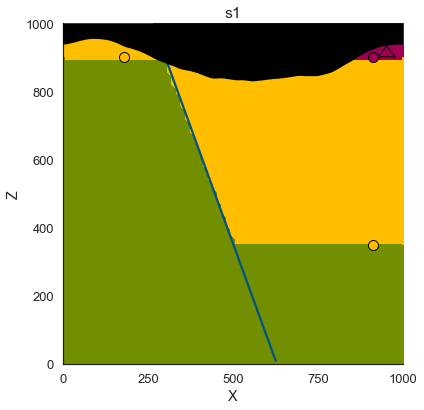

In [6]:
if mode == 'map':
    gp.plot.plot_section_by_name(geo_model, 's1', show_all_data=True)
#plt.savefig('input_data.svg')

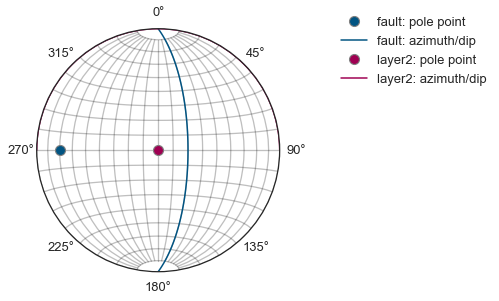

In [7]:
gp.plot.plot_stereonet(geo_model, litho=['fault', 'layer2'])
#plt.savefig('stereonet.svg')

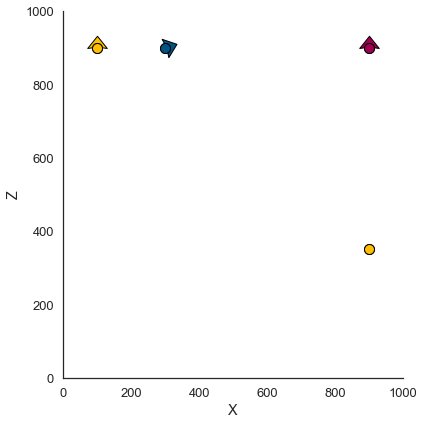

In [8]:
gp.plot.plot_data(geo_model, direction='y')
#plt.savefig('inputlegend.svg')

12.314373044217518


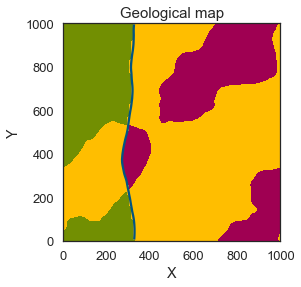

In [9]:
if mode == 'map':
    gp.plot.plot_map(geo_model)

p1 [0.0, 400.0] p2 [1000.0, 400.0]


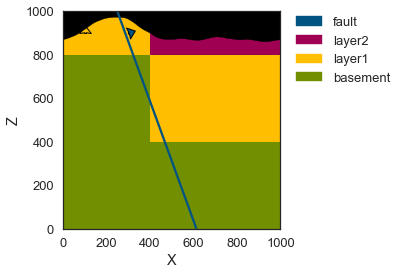

In [10]:
gp.plot.plot_section(geo_model, cell_number=2, show_legend=True, show_topo=True)

### Define random functions for input data

##### Location uncertainty

In [11]:
# in order to move the location of the fault, copy the values of the initial dataframe:
import copy
west_east = copy.copy(geo_model.surface_points.df['X'])
north_south = copy.copy(geo_model.surface_points.df['Y'])
depth = copy.copy(geo_model.surface_points.df['Z'])

##### Orientation uncertainty

Preparation to modify the orientation of the fault:

In [12]:
# import fisher distribution package
import gempy.utils.fishdist as fish

To fit a spherical distribution to the orientation measurements, spherecluster must be installed.


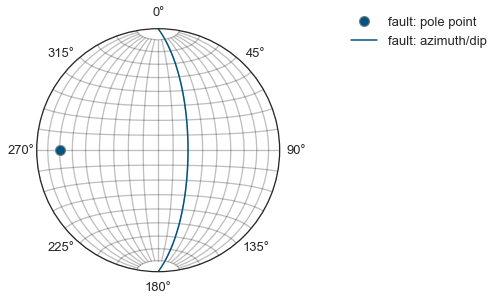

In [13]:
gp.plot.plot_stereonet(geo_model, litho=['fault'])

Von Mises Fisher distribution
Formation:'fault'
Mean orientation = (90, 69)
Kappa = 50



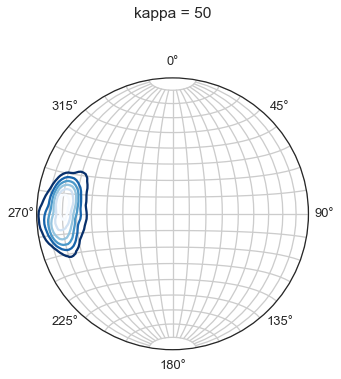

In [45]:
# this cell is just to see how it works
fault_mean = geo_model.orientations.df.loc[geo_model.orientations.df['surface'] == 'fault', ['G_x', 'G_y', 'G_z']].values[0]
fishdist = fish.vMF(name='fault', mean=fault_mean, kappa=50)
print(fishdist)
fishdist.sample(num_samples=50)
# visualize possible samples from spherical distribution
fishdist.plot_stereonet(poles=False)

In [49]:
# make a copy of the initial dataframe
orient = geo_model.orientations.df.copy()
# define concentration parameter for input data
kappadict = {'layer2':30, 'layer1':30, 'fault': 40}

#assign kappa values to the copied dataframe
for surface, kappa in kappadict.items():
    orient.loc[orient['surface'] == surface, 'kappa'] = kappa

# --> orient has new column with kappa
# take only kappa values (they are in right order now)
kappas = orient['kappa']

In [50]:
geo_model.orientations.df

X    Y    Z       X_r     Y_r       Z_r           G_x           G_y  \
0  300  500  900  0.388989  0.5001  0.652878  9.396926e-01  1.000058e-12   
2  900  500  900  0.722322  0.5001  0.652878  1.000000e-12  1.000000e-12   
1  100  500  900  0.277878  0.5001  0.652878  1.000000e-12  1.000000e-12   

       G_z  dip  azimuth  polarity surface        series  id  order_series  \
0  0.34202   70       90         1   fault  fault_series   1             1   
2  1.00000    0        0         1  layer2   form_series   2             2   
1  1.00000    0        0         1  layer1   form_series   3             2   

   smooth  
0    0.01  
2    0.01  
1    0.01

In [59]:
def create_vMF_list(geo_model, kappas, datatype = 'all'):
    faultsdf = geo_model.faults.df
    orientdf = geo_model.orientations.df
    vMF_list=[]
    if datatype == 'faultsonly':
        faults=list(faultsdf[faultsdf['isFault']==True].index)
        df = orientdf[orientdf.surface.isin(faults)]
    elif datatype == 'lithonly':
        notfaults = list(faultsdf[faultsdf['isFault']==False].index)
        df = orientdf[orientdf.series.isin(notfaults)]
    elif datatype == 'all':
        df = orientdf
    else:
        print('nö.')
    for e, i in df[['G_x', 'G_y', 'G_z']].iterrows():
        a=0
        vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=kappas[a]))
        a+=1
    return vMF_list

In [60]:
vMF_list=create_vMF_list(geo_model, kappas, datatype = 'all')

In [61]:
# in this list, a distribution for every orientation data point is stored.
# later we can use it for sampling
vMF_list

[Von Mises Fisher distribution
 Formation:'vMF_0'
 Mean orientation = (90, 69)
 Kappa = 40, Von Mises Fisher distribution
 Formation:'vMF_2'
 Mean orientation = (45, 0)
 Kappa = 40, Von Mises Fisher distribution
 Formation:'vMF_1'
 Mean orientation = (45, 0)
 Kappa = 40]

#### Setup variables for entropy computation

In [64]:
# unique lith ids
lith_id = np.unique(np.round(geo_model.solutions.lith_block).astype(int))

# solution arrays
if mode == 'map':
    geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int)[0]
    count_map = np.zeros((len(lith_id), geomap.shape[0]))
    section1  = np.round(geo_model.solutions.sections[0]).astype(int)[0]
    #init counters
    count_section = np.zeros((len(lith_id), section1.shape[0]))
elif mode == '3Dblock':
    block = np.round(geo_model.solutions.lith_block).astype(int)
    count_block = np.zeros((len(lith_id), block.shape[0]))

### Do the simulation

In [85]:
datatype = 'all' # lithonly for only lithology data, faultonly for only fault data, all for all data
spec = '2_' # just another variable to not overwrite saved things

n_iter=1 #number of iterations

orientation_uncertainty = True

location_uncertainty = False

save = True
n_fig_save = 10

for i in range(n_iter):
    print(i)
   
    if datatype == 'all':
        mask_orient = np.ones(len(geo_model.orientations.df), dtype=bool)
        mask_surfpoints = np.ones(len(geo_model.surface_points.df), dtype=bool)
    elif datatype == 'lithonly':
        notfaults = list(geo_model.faults.df[geo_model.faults.df['isFault']==False].index)
        mask_orient = geo_model.orientations.df.series.isin(notfaults)
        mask_surfpoints = geo_model.surface_points.df.series.isin(notfaults)
    elif datatype == 'faultsonly':
        faults = list(geo_model.faults.df[geo_model.faults.df['isFault']==True].index)
        mask_orient = geo_model.orientations.df.series.isin(faults)
        mask_surfpoints = geo_model.surface_points.df.series.isin(faults)
    
      
    if orientation_uncertainty:
        new_orientations = np.vstack(list(map(lambda x: x.sample(num_samples=1, 
                                                             direct_output=True)[0], 
                                          vMF_list)))
        a=fish.vMF()
        a.add_orientation_data(new_orientations)
        
        indexes = geo_model.orientations.df[mask_orient].index
        geo_model.modify_orientations(indexes,  G_x = new_orientations[mask_orient][:,0],
                                                G_y = new_orientations[mask_orient][:,1],
                                                G_z = new_orientations[mask_orient][:,2],
                                                azimuth = a.samples_azdip[mask_orient][:,0],
                                                dip = a.samples_azdip[mask_orient][:,1])     
    
    if location_uncertainty:
        indexes = geo_model.surface_points.df[mask_surfpoints].index
        shape = len(indexes)
        we = west_east[mask_surfpoints] + np.random.normal(0, 70, shape)
        ns = north_south[mask_surfpoints] + np.random.normal(0, 70, shape)
        d = depth[mask_surfpoints] + np.random.normal(0, 70, shape)
        geo_model.modify_surface_points(indexes, X=we, Y=ns, Z=d)

    geo_model.update_to_interpolator()
    
    _=gp.compute_model(geo_model, compute_mesh=False)
    
    ##### plot #####
    if save == True:
        if i < n_fig_save: # to see how the models look like, save the first 10 sections and maps.
            if mode == 'map':
                plt.clf()
                gp.plot.plot_section_by_name(geo_model, 's1', show_data=False)
                plt.savefig(r'figures/s1_'+datatype+str(i)+'.svg')

                #gp.plot.plot_map(geo_model,show_data=False, contour_lines=False)
                #plt.savefig(r'figures/map_'+datatype+str(i)+'.svg')
    
    ##### calculate and update probability fields #####
    if mode == 'map':
        geomap  = np.round(geo_model.solutions.geological_map[0]).astype(int)[0]
        section1  = np.round(geo_model.solutions.sections[0]).astype(int)[0]
    elif mode == '3Dblock':
        block = np.round(geo_model.solutions.lith_block).astype(int)
    
    for i, l_id in enumerate(lith_id): #enumerate through all liths
        if mode == 'map':
            count_map[i][geomap == l_id] += 1 #sum up frequency
            count_section[i][section1 == l_id] += 1 
        elif mode == '3Dblock':
            count_block[i][block == l_id] +=1 #block is raveled so no need for indexing

#### finish probability calculation and save as numpy arrays ####
if mode == 'map':   
    prob_map = count_map/n_iter
    np.save(r'../models/prob_map_'+datatype+spec+str(n_iter),prob_map)
    prob_section = count_section/n_iter
    np.save(r'../models/prob_sections_'+datatype+spec+str(n_iter),prob_section)
    
elif mode == '3Dblock':
    prob_block = count_block/n_iter
    np.save(r'../models/prob_block_'+datatype+spec+str(n_iter),prob_block)

print('done')

0
[[ 0.8856985  -0.0229071   0.46369541]
 [ 0.0367532   0.01632717  0.99919099]
 [ 0.06611286  0.06232433  0.99586383]]
done


### Visualize results

In [74]:
from matplotlib.ticker import FixedFormatter, FixedLocator
from gempy.plot import helpers
import matplotlib.colors as mcolors

In [75]:
from gempy.plot import visualization_2d
plot = visualization_2d.PlotSolution(geo_model)

In [76]:
from matplotlib.ticker import FixedFormatter, FixedLocator
from gempy.plot import helpers

def plot_probabilities(plot, block, shape, T = False, extent=None):
    fig, ax = plt.subplots(int(np.ceil(block.shape[0]/2)), 2, figsize=(20, 20))
    ax = ax.flatten()
    print(int(np.ceil(block.shape[0]/2)))
    print(block.shape)
    for i in range(block.shape[0]):
        allcolors = list(plot._color_lot.values())[plot.model.faults.n_faults:]
        formnames = list(plot._color_lot.keys())[plot.model.faults.n_faults:]
        c2 = allcolors[i]
        title = formnames[i]
        cmap = mcolors.LinearSegmentedColormap.from_list('c',['#FFFFFF',c2])
        if T:
            plotblock = block[i].reshape(shape).T
        else:
            plotblock = block[i].reshape(shape)
        im = ax[i].imshow(plotblock, origin='lower', cmap=cmap,
                    extent = extent)
        ax[i].set_title(title)
        helpers.add_colorbar(im, label='probability')
    fig.tight_layout()
    
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

def plot_section_by_name(self, section_name, image=None, show_data=True, show_faults=True, show_topo=True,
                         show_all_data=False, cmap='viridis', label='cell entropy', title=None, **kwargs):
    assert type(section_name) == str, 'section name must be a string of the name of the section'
    #assert self.model.solutions.sections is not None, 'no sections for plotting defined'

    j = np.where(self.model.grid.sections.names == section_name)[0][0]
    l0, l1 = self.model.grid.sections.get_section_args(section_name)
    shape = self.model.grid.sections.resolution[j]
    if image is None:
        image = self.model.solutions.sections[0][0][l0:l1].reshape(shape[0], shape[1]).T
    else: image = image.reshape(shape[0], shape[1]).T
    extent = [0, self.model.grid.sections.dist[j][0],
              self.model.grid.regular_grid.extent[4], self.model.grid.regular_grid.extent[5]]


    if show_data:
        self.plot_section_data(section_name=section_name, show_all_data=show_all_data, **kwargs)

    axes = plt.gca()
    im=axes.imshow(image, origin='lower', zorder=-100,
                cmap=cmap, extent=extent)
    if show_faults:
        self.extract_section_fault_lines(section_name, axes)

    if show_topo:
        if self.model.grid.topography is not None:
            alpha = kwargs.get('alpha', 1)
            xy = self.make_topography_overlay_4_sections(j)
            axes.fill(xy[:, 0], xy[:, 1], 'k', zorder=10, alpha=alpha)

    labels, axname = self._make_section_xylabels(section_name, len(axes.get_xticklabels()) - 2)
    pos_list = np.linspace(0, self.model.grid.sections.dist[j], len(labels))
    axes.xaxis.set_major_locator(FixedLocator(nbins=len(labels), locs=pos_list))
    axes.xaxis.set_major_formatter(FixedFormatter((labels)))
    if title is None:
        title=self.model.grid.sections.names[j]
    axes.set(title=title, xlabel=axname, ylabel='Z')
    helpers.add_colorbar(im, label=label)

In [77]:
prop_section=np.load(r'../models/prob_sections_all2_100.npy')
section_ie = calculate_ie_masked(prop_section)

2
(3, 6400)


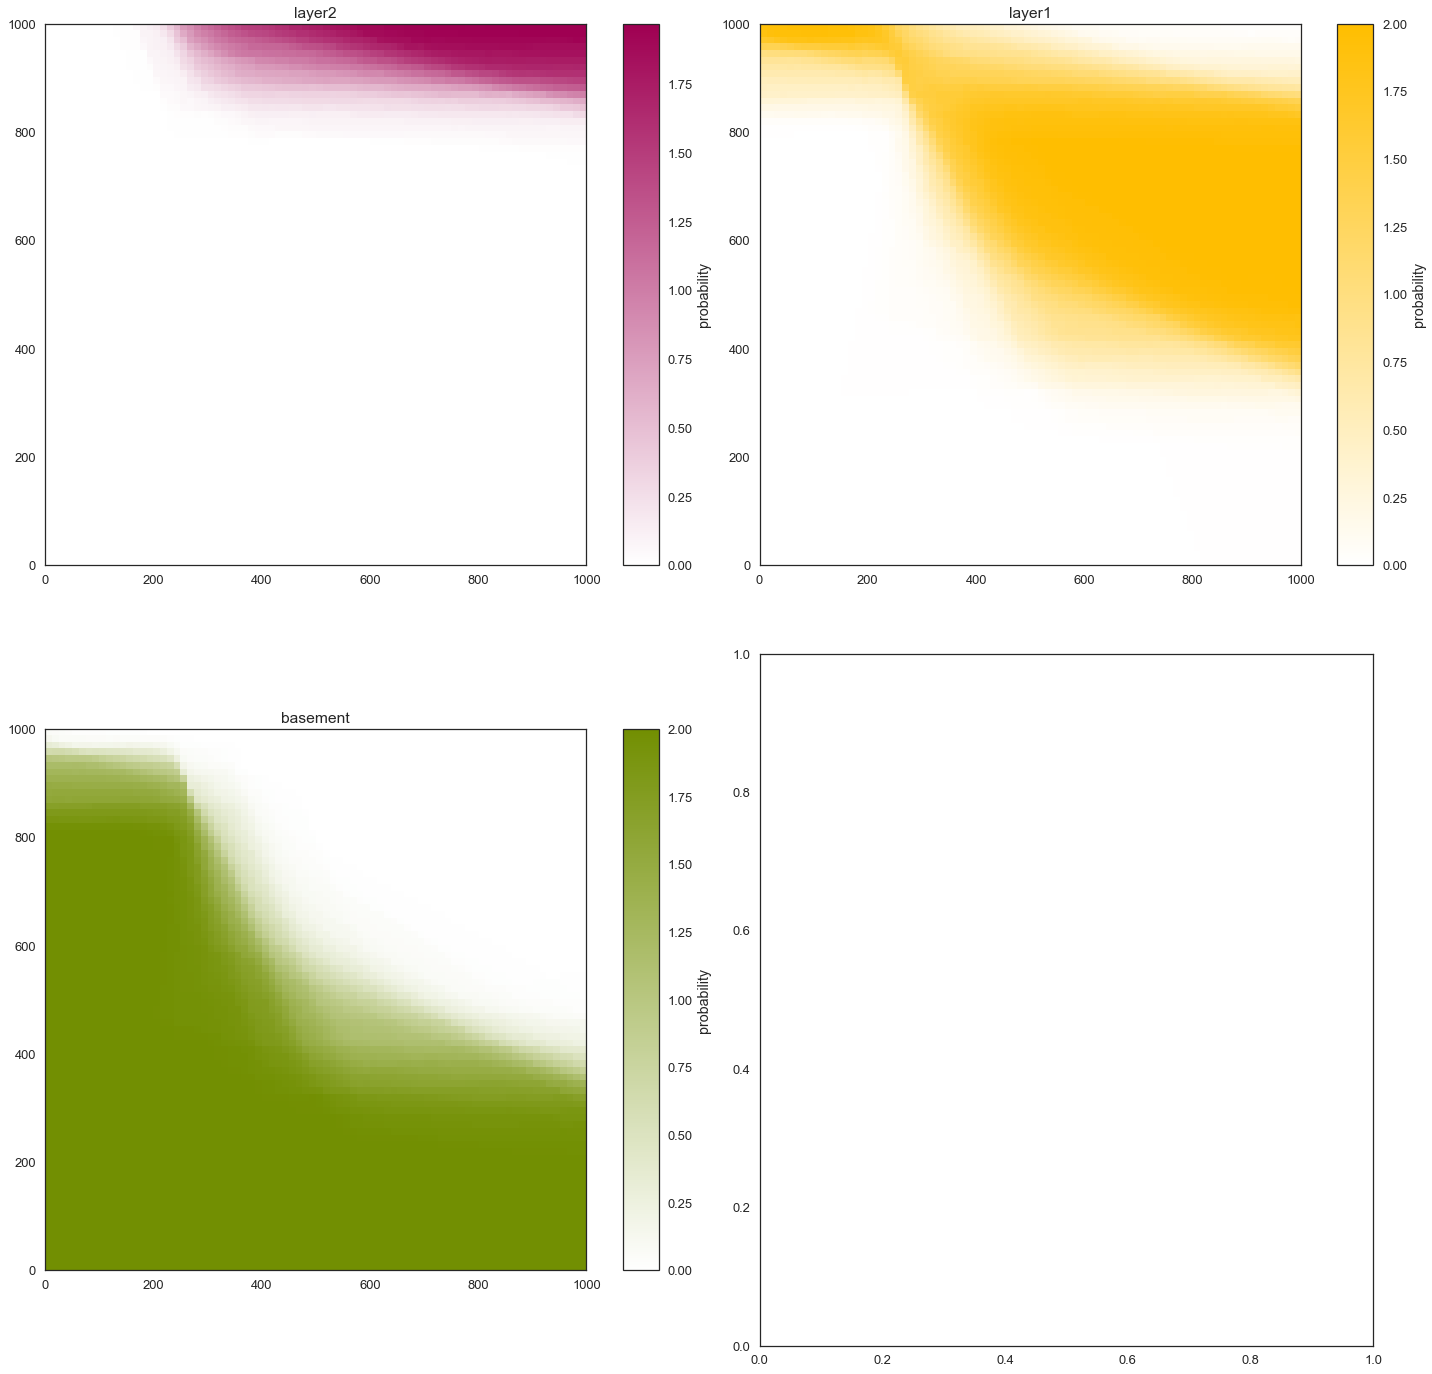

In [78]:
plot_probabilities(plot, prop_section, geo_model.grid.sections.resolution[0],
                  T=True, extent=[0,1000,0,1000])

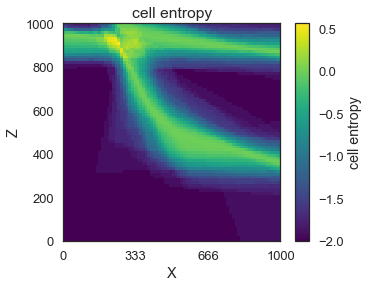

In [79]:
plot_section_by_name(plot, 's1', image = section_ie, cmap='viridis', show_data=False, show_faults=False,
                    label='cell entropy', title='cell entropy', show_topo=False)